# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

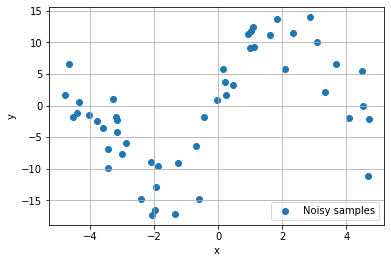

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

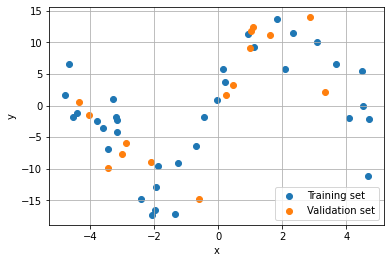

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

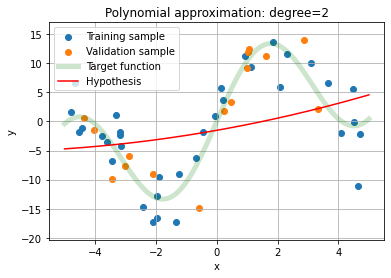

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

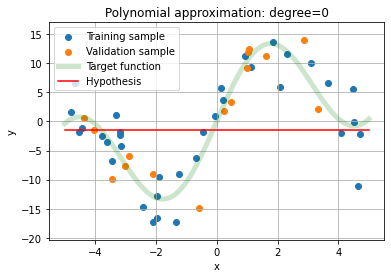

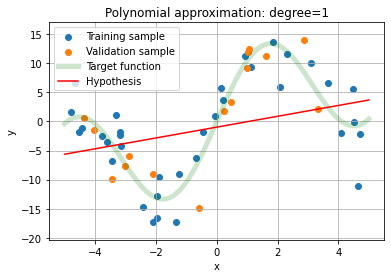

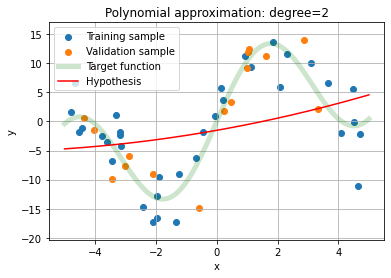

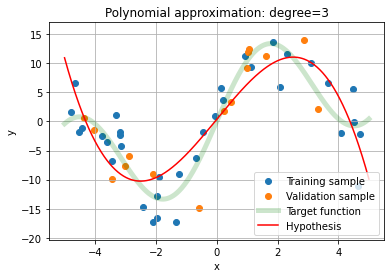

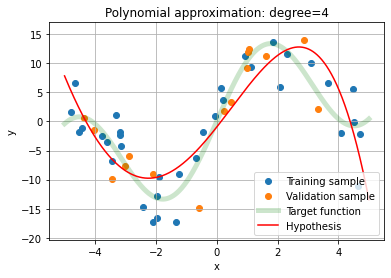

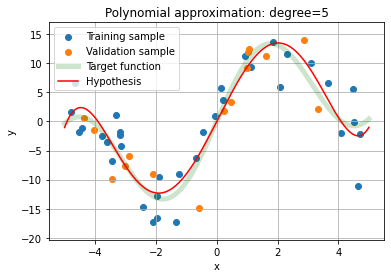

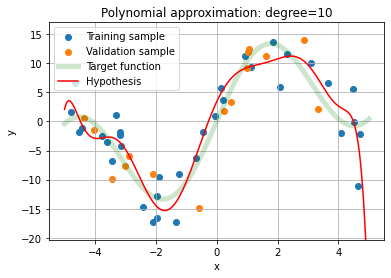

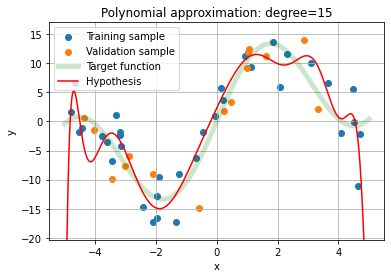

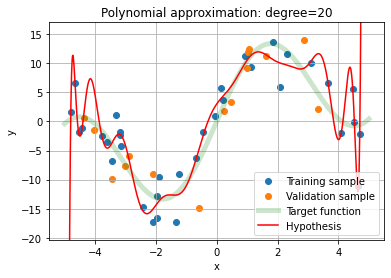

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

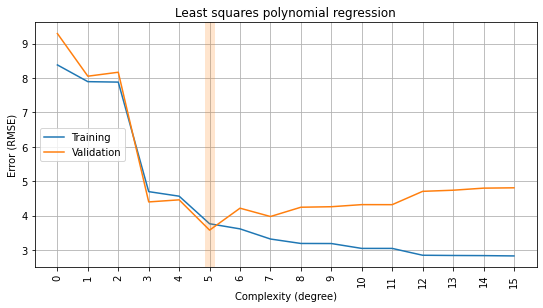

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

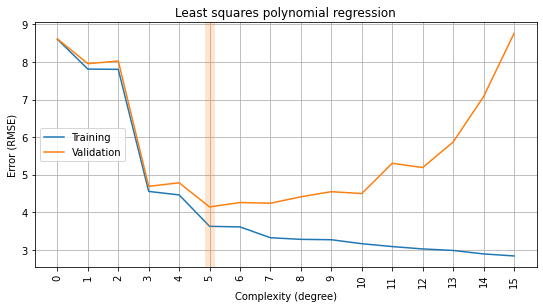

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

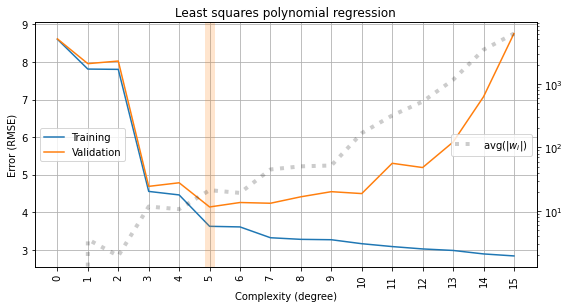

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

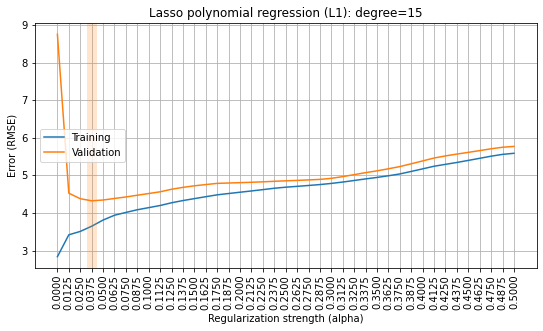

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

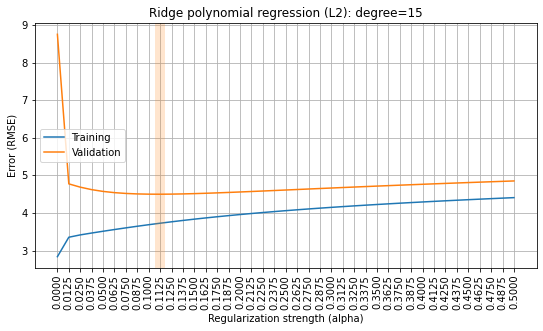

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

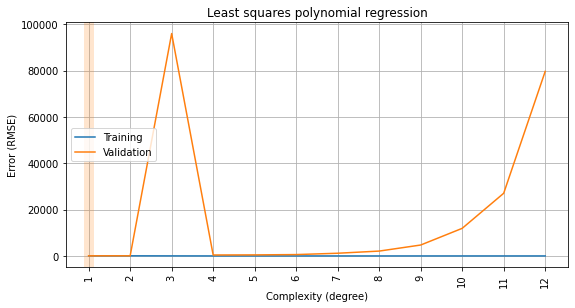

In [21]:
def create_poly(degree, x, y, regressor):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    poly_fit_train_data = pf.fit_transform(x)
    lr = regressor
    lr.fit(poly_fit_train_data, y)
    return lr

def predict_poly(poly, degree, test):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    poly_test_data = pf.fit_transform(test)
    return poly.predict(poly_test_data)

def create_model(degree, scaled_X_train, scaled_X_test, Y_train, Y_test, alpha, penalty):
    regressor = LinearRegression()
    if alpha == 0:
        pass
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    pol_for_degree = create_poly(degree, scaled_X_train, Y_train, regressor)
    y_train_pred = predict_poly(pol_for_degree, degree, scaled_X_train)
    y_test_pred = predict_poly(pol_for_degree, degree, scaled_X_test)
    rmse_train.append(rmse(y_train_pred, Y_train))
    rmse_valid.append(rmse(y_test_pred, Y_test))
    return pol_for_degree
    
DEGREES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # I select only 12 due to processing limitations of Kaggle
rmse_train, rmse_valid = [], []

X_train, X_test, Y_train, Y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

for degree in DEGREES:
    create_model(degree, scaled_X_train, scaled_X_test, Y_train, Y_test, 0, "")
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

We observe the following tendencies:
- Underfitting (degree < 8 (except degree 3)): The model shows equal result for train and test.
- Well-fit model (degree = 8): The model is able to capture the underlying data distribution and fits well train and test.
- Overfitting (degree = 3 or degree > 8): While the fit for the training data gets even better, the fit for the validation set gets worse.
- As the degree of polynomial increases, the linear model coefficients become more likely to take on large values.



### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

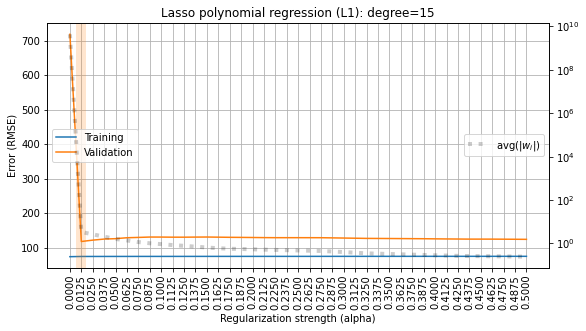

In [22]:
# Due to extreme processing power and time, I will use only some of the features
X_train, X_test, Y_train, Y_test = train_test_split(X_diabetes[['age', 'sex']], y_diabetes, test_size=0.3, random_state=SEED)
rmse_train, rmse_valid = [], []
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Supress warnings in kaggle
import warnings
warnings.filterwarnings('ignore')

lasso_coefs = []
for alpha in ALPHAS:
    lr = create_model(15, scaled_X_train, scaled_X_test, Y_train, Y_test, alpha, 'L1')
    res = cross_validate(lr, X_diabetes[['age', 'sex']], y_diabetes, cv=5, return_estimator=True,scoring='neg_root_mean_squared_error')
    lasso_coefs.append(np.mean([            
            np.abs(lr.coef_)
            for model in res['estimator']
        ]))

plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=lasso_coefs, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

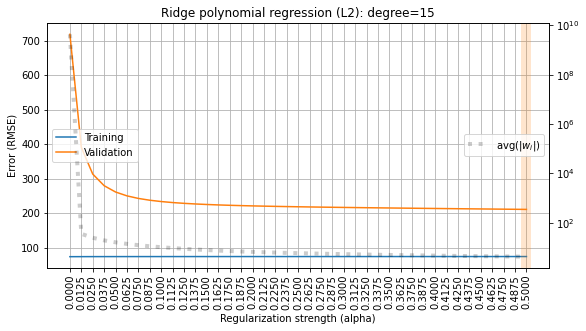

In [23]:
# Due to extreme processing power and time, I will use only some of the features
X_train, X_test, Y_train, Y_test = train_test_split(X_diabetes[['age', 'sex']], y_diabetes, test_size=0.3, random_state=SEED)
rmse_train, rmse_valid = [], []
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Supress warnings in kaggle
import warnings
warnings.filterwarnings('ignore')

ridge_coefs = []
for alpha in ALPHAS:
    lr = create_model(15, scaled_X_train, scaled_X_test, Y_train, Y_test, alpha, 'L2')
    res = cross_validate(lr, X_diabetes[['age', 'sex']], y_diabetes, cv=5, return_estimator=True,scoring='neg_root_mean_squared_error')
    ridge_coefs.append(np.mean([            
            np.abs(lr.coef_)
            for model in res['estimator']
        ]))

plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=ridge_coefs, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary

Regularization helps to prevent our model from overfitting by setting constraints to the polynomial features that lead to the overfitting of our model. This is indeed happening, both for L1 and L2, and it is clearly shown on the provided plots (keep in mind that the model was build only for two features due to limiting processing power). 
- In case of L1, even a small value of alpha improved the model significantly: on the plot the validation drops down close to the training curve. 
- In case of L2, the situation is the same, but the angle of the curve is not so radical, and rather smoother.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [24]:
# Due to extreme processing power and time, I will use only some of the features
X_train, X_test, Y_train, Y_test = train_test_split(X_diabetes[['age', 'sex']], y_diabetes, test_size=0.3, random_state=SEED)
rmse_train, rmse_valid = [], []
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

lasso_coefs = []
for alpha in ALPHAS:
    lr = create_model(7, scaled_X_train, scaled_X_test, Y_train, Y_test, alpha, 'L1')
    lasso_coefs.append(lr.coef_)

df = pd.DataFrame(np.row_stack(lasso_coefs))
df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,2.997248,-1.186155,3.184503,4.830292,-0.130713,-1.111306,9.807676,3.529543,-1.200559,-2.301445,...,5.671580,-0.398509,-0.935467,4.342384,2.761501,-12.992293,-3.159711,10.872554,4.729703,-1.273458
1,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,...,13.533989,-0.000000,-0.845325,4.241300,2.950356,-18.184944,-3.966578,29.056716,13.120216,-4.670068
2,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,...,13.348733,-0.000000,-0.755184,4.140215,2.897945,-20.462010,-2.537338,28.212543,12.372949,-4.450420
3,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,...,13.163477,-0.000000,-0.665042,4.039131,2.828773,-22.728239,-1.108098,27.368370,11.625682,-4.230773
4,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,...,12.960044,-0.000000,-0.593585,3.953081,2.469311,-23.070170,-0.000000,26.642695,11.054540,-4.031437
5,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,...,12.601982,-0.000000,-0.577502,3.886143,2.407324,-22.679502,-0.000000,26.068732,11.136683,-3.861931
6,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,...,12.243930,-0.000000,-0.561419,3.819207,2.345340,-22.288849,-0.000000,25.494791,11.218821,-3.692428
7,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,...,11.897597,-0.000000,-0.539042,3.749416,2.231543,-21.882565,-0.000000,24.899818,11.231500,-3.518942
8,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,...,11.619684,-0.000000,-0.491279,3.668965,1.905250,-21.414670,-0.000000,24.218041,10.952080,-3.329098
9,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,...,11.307314,-0.000000,-0.456636,3.593347,1.689464,-20.973969,-0.000000,23.573676,10.826586,-3.146794


#### L2

In [25]:
# Due to extreme processing power and time, I will use only some of the features
X_train, X_test, Y_train, Y_test = train_test_split(X_diabetes[['age', 'sex']], y_diabetes, test_size=0.3, random_state=SEED)
rmse_train, rmse_valid = [], []
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

ridge_coefs = []
for alpha in ALPHAS:
    lr = create_model(7, scaled_X_train, scaled_X_test, Y_train, Y_test, alpha, 'L2')
    ridge_coefs.append(lr.coef_)

df = pd.DataFrame(np.row_stack(ridge_coefs))
df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,2.997248,-1.186155,3.184503,4.830292,-0.130713,-1.111306,9.807676,3.529543,-1.200559,-2.301445,...,5.671580,-0.398509,-0.935467,4.342384,2.761501,-12.992293,-3.159711,10.872554,4.729703,-1.273458
1,2.995664,-1.184760,3.187774,4.827126,-0.130560,-1.105540,9.799000,3.527610,-1.199147,-2.305545,...,5.667947,-0.398040,-0.933858,4.339380,2.756055,-12.983783,-3.152533,10.864286,4.726998,-1.271961
2,2.994086,-1.183367,3.191031,4.823965,-0.130406,-1.099794,9.790343,3.525684,-1.197738,-2.309630,...,5.664321,-0.397572,-0.932254,4.336383,2.750625,-12.975289,-3.145379,10.856034,4.724301,-1.270466
3,2.992516,-1.181978,3.194274,4.820810,-0.130253,-1.094068,9.781704,3.523765,-1.196331,-2.313700,...,5.660702,-0.397105,-0.930655,4.333393,2.745212,-12.966814,-3.138246,10.847798,4.721613,-1.268974
4,2.990951,-1.180590,3.197504,4.817661,-0.130100,-1.088362,9.773084,3.521854,-1.194927,-2.317755,...,5.657091,-0.396639,-0.929060,4.330408,2.739815,-12.958355,-3.131137,10.839579,4.718933,-1.267485
5,2.989394,-1.179206,3.200720,4.814517,-0.129948,-1.082676,9.764482,3.519950,-1.193526,-2.321795,...,5.653486,-0.396174,-0.927470,4.327430,2.734435,-12.949914,-3.124050,10.831375,4.716262,-1.265998
6,2.987843,-1.177824,3.203922,4.811378,-0.129795,-1.077010,9.755899,3.518053,-1.192127,-2.325820,...,5.649888,-0.395710,-0.925884,4.324458,2.729071,-12.941489,-3.116985,10.823188,4.713600,-1.264514
7,2.986299,-1.176444,3.207111,4.808244,-0.129643,-1.071363,9.747333,3.516164,-1.190731,-2.329831,...,5.646298,-0.395246,-0.924303,4.321493,2.723723,-12.933082,-3.109943,10.815017,4.710946,-1.263033
8,2.984761,-1.175067,3.210286,4.805116,-0.129492,-1.065736,9.738786,3.514281,-1.189337,-2.333827,...,5.642714,-0.394784,-0.922726,4.318534,2.718392,-12.924692,-3.102923,10.806861,4.708301,-1.261555
9,2.983229,-1.173693,3.213448,4.801993,-0.129340,-1.060128,9.730258,3.512406,-1.187946,-2.337809,...,5.639138,-0.394322,-0.921154,4.315580,2.713076,-12.916319,-3.095925,10.798721,4.705665,-1.260079


#### Summary
Yes, indeed. L1 regularisation has a sparcity effect, and there are many zero weights as shown in the first table above (dataframes where we put the weights in) above.
In case of L2, we see coefficients that are close to zero, but none of them are. This is because L2 is calculated using not abs value differences, but square of differences.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [26]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

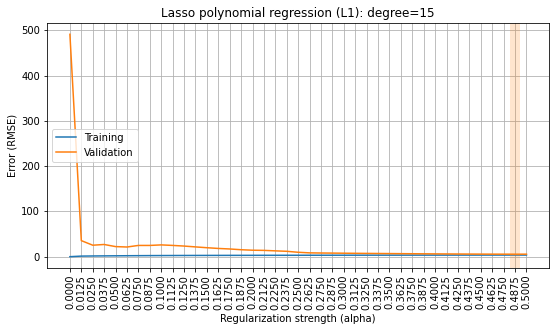

In [27]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

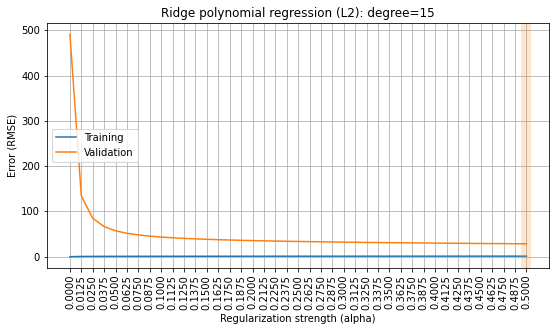

In [28]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary
Yes, scaling is extremely important. If allows us to build better machine learning models, when taking into consideration multiple features. Semantics and impact of different features is not known to the computer, and without scaling (or other data normalization methods) the way two numeric features will be compared is by using their numeric values. However, this does not always mean that large numeric values for one feature have a larger impact of the target feature. If scaling is not performed on the data then during regularization coefficients will not be penalized properly.
Scaling also allows us to represent data in more unified way and makes it slightly easier to build plots.
